In [11]:
import os
import pickle
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Get the current working directory
CURRENT_DIR = os.getcwd()

# Set the root directory to the parent of the current directory
ROOT = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
sys.path.insert(0, ROOT)

from notebooks.plotting_tools import *
from code_.model_configs import analysis_cfg

In [6]:
load_dotenv()
CACHE = os.getenv("CACHE")
RESULTS_PATH = os.path.join(ROOT,'results')

In [13]:
MULTIPLIER = 36

def load_and_prepare_data(model_name, multiplier, dataset, region):
    filepath = os.path.join(RESULTS_PATH, model_name + '_' + dataset + '_' + region + '.pkl')
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
    df['model'] = model_name
    df['features'] = df['features'].apply(lambda x: int(x) * multiplier)
    df['score'] = df['score'].astype(np.float32)
    return df

In [43]:
DATASET = 'naturalscenes' # one of ['majajhong', 'naturalscenes']
region = analysis_cfg[DATASET]['regions']

# Effect of activation function 

In [29]:
# loading linear model data
df_linear = load_and_prepare_data('linear_model', MULTIPLIER, DATASET, region)
# loading linear model data
df_expansion = load_and_prepare_data('expansion', MULTIPLIER, DATASET, region)
#join dataframes
df = pd.concat([df_linear,df_expansion]).reset_index(drop=True)

# alexnet data
with open(os.path.join(RESULTS_PATH, 'alexnet' + '_' + DATASET + '_' + region + '.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

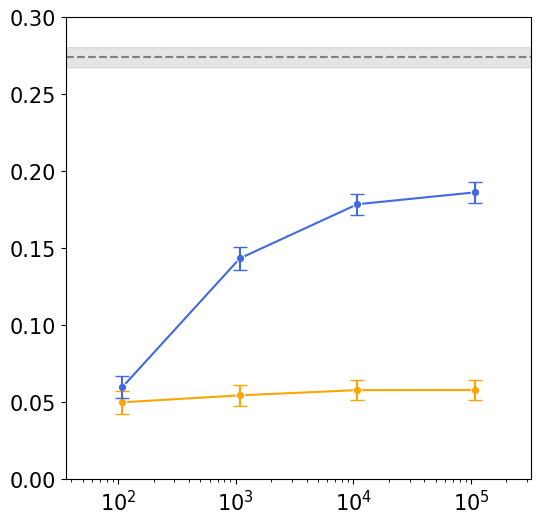

In [30]:
names ={'expansion':'ReLU','linear_model':'Linear'}
palette ={'ReLU':'royalblue','Linear':'orange'}
df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], 
                       [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])


# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], 
                 df_alexnet['upper'], 
                 color='gray', alpha=0.2)


plt.ylim(0,0.30) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
plt.xlabel('')
plt.ylabel('')    
ax1.legend(frameon=False,fontsize=12) if region == 'IT' else ax1.legend_.remove()
plt.savefig(os.path.join(ROOT,f'figures/figure_5_activation_function_{DATASET}_{region}.png'), dpi=200) 
plt.show()

# Effects of local connectivity

In [36]:


# loading linear model data
df_shuffled = load_and_prepare_data('shuffled_data', MULTIPLIER, DATASET+'_shuffled', region)
# loading linear model data
df_expansion = load_and_prepare_data('expansion', MULTIPLIER, DATASET, region)
#join dataframes
df = pd.concat([df_linear,df_expansion]).reset_index(drop=True)

# alexnet data
with open(os.path.join(RESULTS_PATH, 'alexnet' + '_' + DATASET + '_' + region + '.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

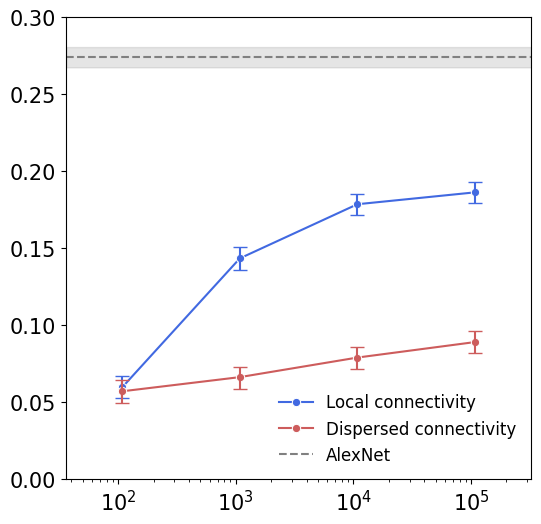

In [39]:
df_expansion['dataset'] = 'Local connectivity'
df_shuffled['dataset'] = 'Dispersed connectivity'
df = pd.concat([df_expansion,df_shuffled]).reset_index(drop=True)
names ={'expansion':'Expansion'}
palette ={'Local connectivity':'royalblue','Dispersed connectivity':'indianred'}
df['model'] = df['model'].map(names)
df['color'] = df['dataset'].map(palette)

rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='dataset', marker='o',palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])
    
# alexnet results
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')
# adding confidence interval
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='gray', alpha=0.2)

plt.xlabel('')
plt.ylabel('')
plt.ylim(0,0.30) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")    
region == 'IT' if ax1.legend(frameon=False,fontsize=12) else ax1.legend_.remove()  
plt.savefig(os.path.join(ROOT, f'figures/figure_5_local_connectivity_{DATASET}_{region}.png'), dpi=200) 
plt.show()

# Scaing effect


In [45]:
DATASET

'naturalscenes'

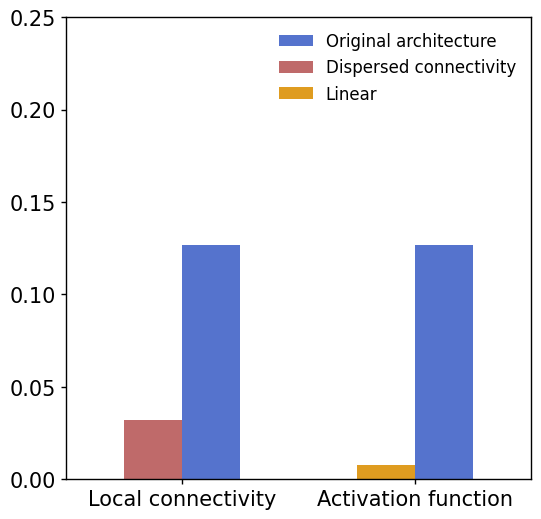

In [51]:
models = ['expansion','linear_model','shuffled_data']
names = {'expansion': 'Original architecture', 'linear_model': 'Linear', 'shuffled_data': 'Dispersed connectivity'}
palette ={'Dispersed connectivity':'indianred','Linear':'orange','Original architecture':'royalblue'}

# Configurations for models and features
min_features, max_features = 108,1080000

# Dataset dependent changes
if DATASET == 'naturalscenes':
    max_features/=10

# Data initialization
ratios_dicts = {model: {'region':[], 'dataset':[], 'model':[], 'smallest model score':[], 
                        'largest model score':[], 'difference':[]} 
                for model in models}

for model_name in models:
    if model_name == 'shuffled_data':
        df_model = load_and_prepare_data(model_name, MULTIPLIER, DATASET+'_shuffled', region)
    else:
        df_model = load_and_prepare_data(model_name, MULTIPLIER, DATASET, region)
    smallest_score = float(df_model[df_model.features == min_features]['score'].item())
    largest_score = float(df_model[df_model.features == max_features]['score'].item())
    
    ratios_dicts[model_name]['region'].append(region)
    ratios_dicts[model_name]['dataset'].append(DATASET)
    ratios_dicts[model_name]['model'].append(model_name)
    ratios_dicts[model_name]['smallest model score'].append(smallest_score)
    ratios_dicts[model_name]['largest model score'].append(largest_score)
    ratios_dicts[model_name]['difference'].append(largest_score - smallest_score)

# Concatenate all dataframes
df_1 = pd.concat([pd.DataFrame.from_dict(ratios_dicts[model]) for model in ['expansion','shuffled_data']]).reset_index(drop=True)
df_1['model'] = df_1['model'].map(names)
df_1['analysis'] = 'Local connectivity'

df_2 = pd.concat([pd.DataFrame.from_dict(ratios_dicts[model]) for model in ['expansion','linear_model']]).reset_index(drop=True)
df_2['model'] = df_2['model'].map(names)
df_2['analysis'] = 'Activation function'

# Plot both datasets
ax1 = sns.barplot(
    x='analysis', 
    y='difference', 
    hue='model', 
    palette=palette, 
    data=df_1.sort_values(by='model'),
    width=0.5)
ax2 = sns.barplot(
    x='analysis', 
    y='difference', 
    hue='model', 
    palette=palette, 
    data=df_2.sort_values(by='model'),
    width=0.5)

handles_1, labels_1 = ax1.get_legend_handles_labels()
handles_to_display_1 = [handles_1[1], handles_1[0], handles_1[2]]
labels_to_display_1 = [labels_1[1], labels_1[0], labels_1[2]]
ax1.legend(handles_to_display_1, labels_to_display_1, loc='best', frameon=False, fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(0,0.25)
for spine in ax1.spines.values():
    spine.set_linewidth(1)
ax1.xaxis.set_tick_params(width=1)
ax1.yaxis.set_tick_params(width=1)
plt.savefig(os.path.join(ROOT,f'figures/figure_5_scaling_effect_{DATASET}_{region}.png'), dpi=200) 
plt.show()